In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
import pickle
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pylab 
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import os
from sklearn.compose import ColumnTransformer

C:\Users\Ian\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Ian\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\Ian\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# **Data Cleaning**

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(train.shape)
train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
df1 = train[train.isna().any(axis=1)]
df1.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
225,226,0,3,"Berglund, Mr. Karl Ivar Sven",male,22.0,0,0,PP 4348,9.3500,NaN,S
231,232,0,3,"Larsson, Mr. Bengt Edvin",male,29.0,0,0,347067,7.7750,NaN,S
130,131,0,3,"Drazenoic, Mr. Jozef",male,33.0,0,0,349241,7.8958,NaN,C
381,382,1,3,"Nakid, Miss. Maria (""Mary"")",female,1.0,0,2,2653,15.7417,NaN,C
635,636,1,2,"Davis, Miss. Mary",female,28.0,0,0,237668,13.0000,NaN,S
385,386,0,2,"Davies, Mr. Charles Henry",male,18.0,0,0,S.O.C. 14879,73.5000,NaN,S
431,432,1,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.1000,NaN,S
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S
677,678,1,3,"Turja, Miss. Anna Sofia",female,18.0,0,0,4138,9.8417,NaN,S


C:\Users\Ian\AppData\Local\Temp/ipykernel_11068/324537713.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  train.hist(ax = axes)


array([[<AxesSubplot:title={'center':'PassengerId'}>,
        <AxesSubplot:title={'center':'Survived'}>,
        <AxesSubplot:title={'center':'Pclass'}>],
       [<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'SibSp'}>,
        <AxesSubplot:title={'center':'Parch'}>],
       [<AxesSubplot:title={'center':'Fare'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

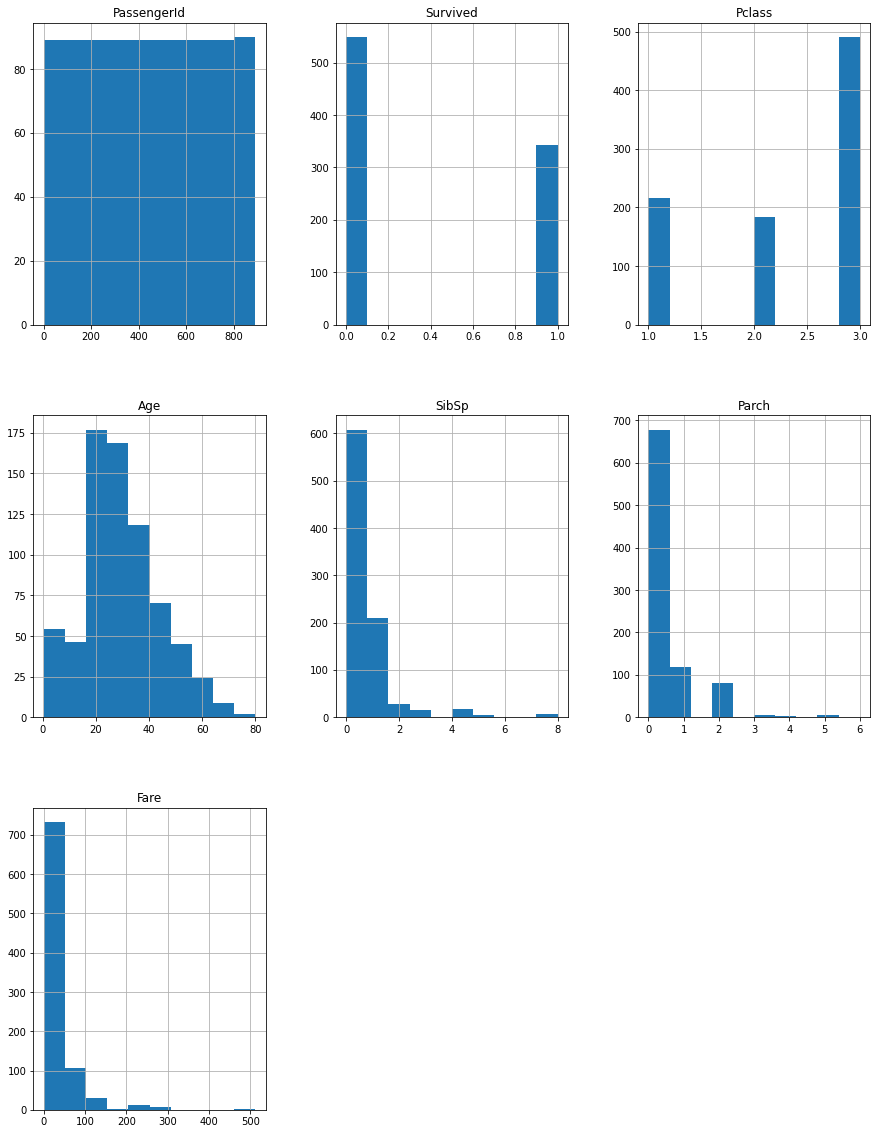

In [5]:
# distribution of each of the variables
fig = plt.figure(figsize=(15, 20))
axes = fig.gca()
train.hist(ax = axes)

**Invalid Data**

In [6]:
#deep copy of training dataset
clean_train = train.copy()

<AxesSubplot:>

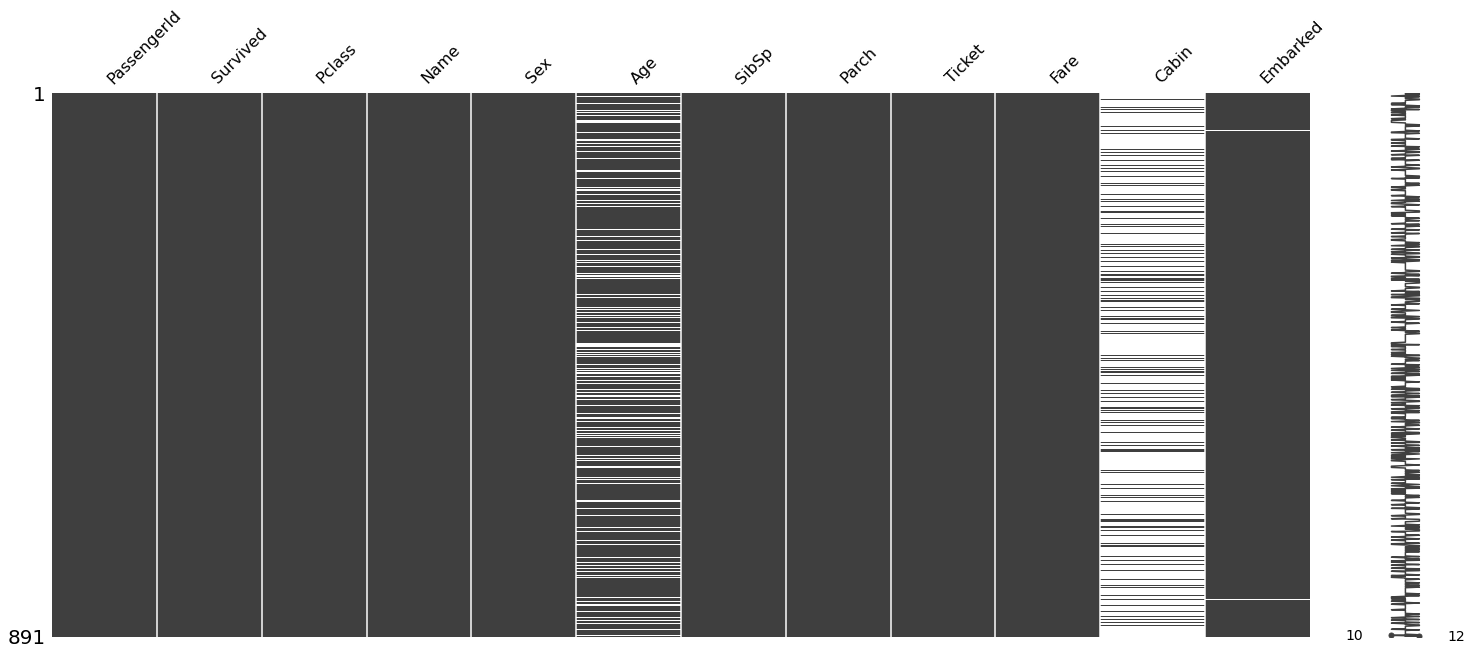

In [7]:
msno.matrix(clean_train)

In [8]:
#all age < 0 are NaN values so going to use data imputation(shown later)
proper_age = clean_train[clean_train['Age']>0]
print(len(clean_train['Age'])-len(proper_age))

177


In [9]:
#dropped all rows with invalid fare
proper_fare = clean_train[clean_train['Fare']>0]
print(len(clean_train['Fare'])-len(proper_fare)) 
print((clean_train[clean_train['Fare']<=0]['Fare']).unique()) #all invalid fares are 0
clean_train = clean_train[clean_train['Fare']>0]

15
[0.]


In [10]:
#dropped Ticket column since 76.5% are unique categorical values
print(len(clean_train['Ticket'].unique())/len(clean_train))
clean_train = clean_train.drop(columns=['Ticket'])

0.7659817351598174


In [11]:
#dropped PassengerID and Name column since all names are unique categorical values
print(len(clean_train['PassengerId'].unique())/len(clean_train))
print(len(clean_train['Name'].unique())/len(clean_train))
clean_train = clean_train.drop(columns=['Name'])
clean_train = clean_train.drop(columns=['PassengerId'])

1.0
1.0


In [12]:
#dropped Cabin column since 77% are NaN values
print(f"Before:\n{clean_train.isnull().sum(axis=0)}")
print(f"\n% of NaN values: {clean_train['Cabin'].isnull().sum(axis=0)/len(clean_train)}")
clean_train = clean_train.drop(columns=['Cabin'])
print(f"\nAfter:\n{clean_train.isnull().sum(axis=0)}")

Before:
Survived      0
Pclass        0
Sex           0
Age         169
SibSp         0
Parch         0
Fare          0
Cabin       675
Embarked      2
dtype: int64

% of NaN values: 0.7705479452054794

After:
Survived      0
Pclass        0
Sex           0
Age         169
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64


<AxesSubplot:>

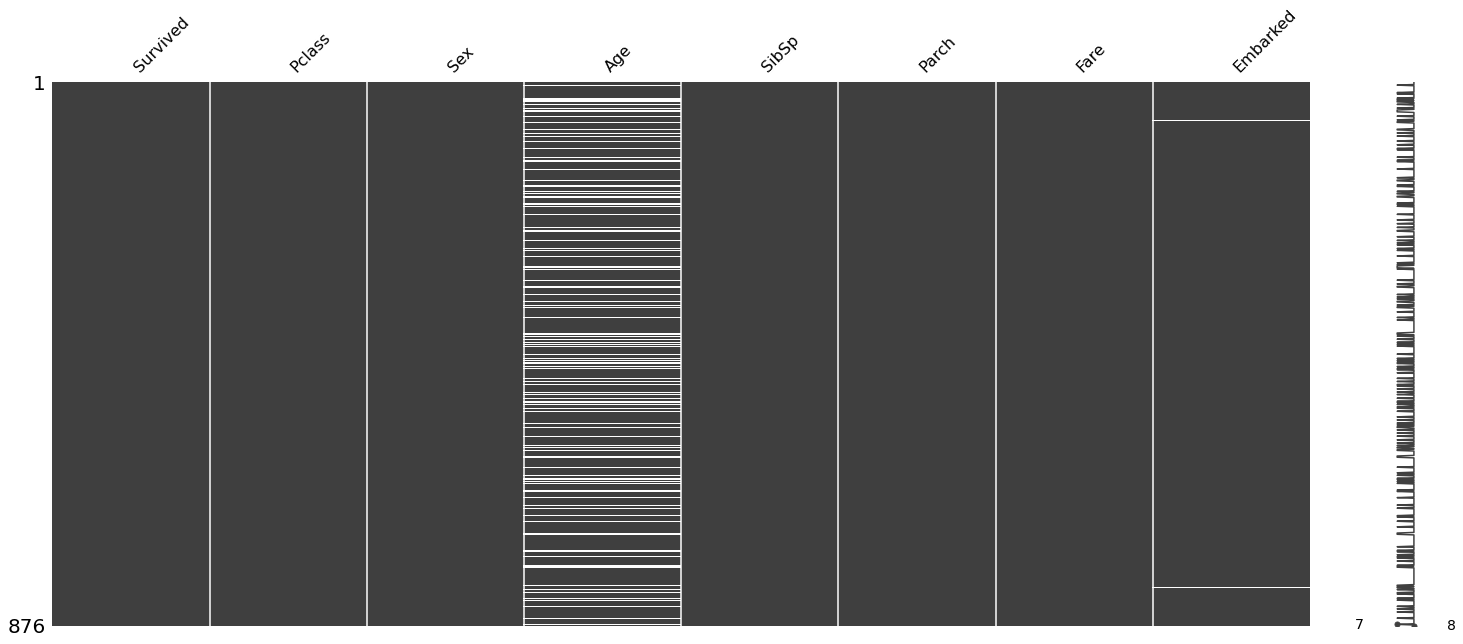

In [13]:
msno.matrix(clean_train)

**Outliers**

In [14]:
clean_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


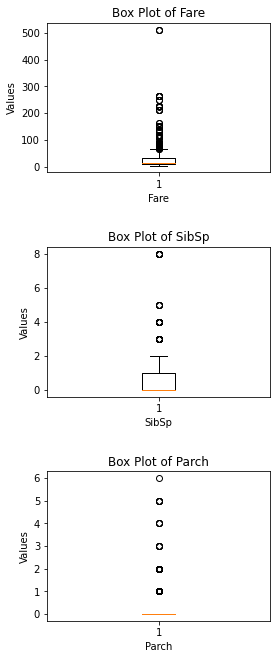

In [15]:
#columns that are skewed based on histogram; creates boxplot for skewed columns
skew = ['Fare','SibSp','Parch']

fig, axes = plt.subplots(nrows=len(skew), figsize=(4,11)) #fig contains subplot, 
                                                                     #an array of subplots

for i, column in enumerate(skew):
    axes[i].boxplot(clean_train[column])
    axes[i].set_title('Box Plot of {}'.format(column))
    axes[i].set_xlabel(column)
    axes[i].set_ylabel("Values")


plt.subplots_adjust(hspace=0.5)
#removing the outliers doesn't seem reasonable as there are only a few and the values are reasonable

**Data Imputation**

In [16]:
#Age column
clean_train['Age'].fillna(clean_train['Age'].mode().iloc[0], inplace=True)

In [17]:
#Embarked column
#print(clean_train[clean_train.isna().any(axis=1)])
clean_train['Embarked'].fillna(clean_train['Embarked'].mode().iloc[0], inplace=True)

In [18]:
print("HERE!")
clean_train.isnull().sum(axis=0)

HERE!


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

<AxesSubplot:>

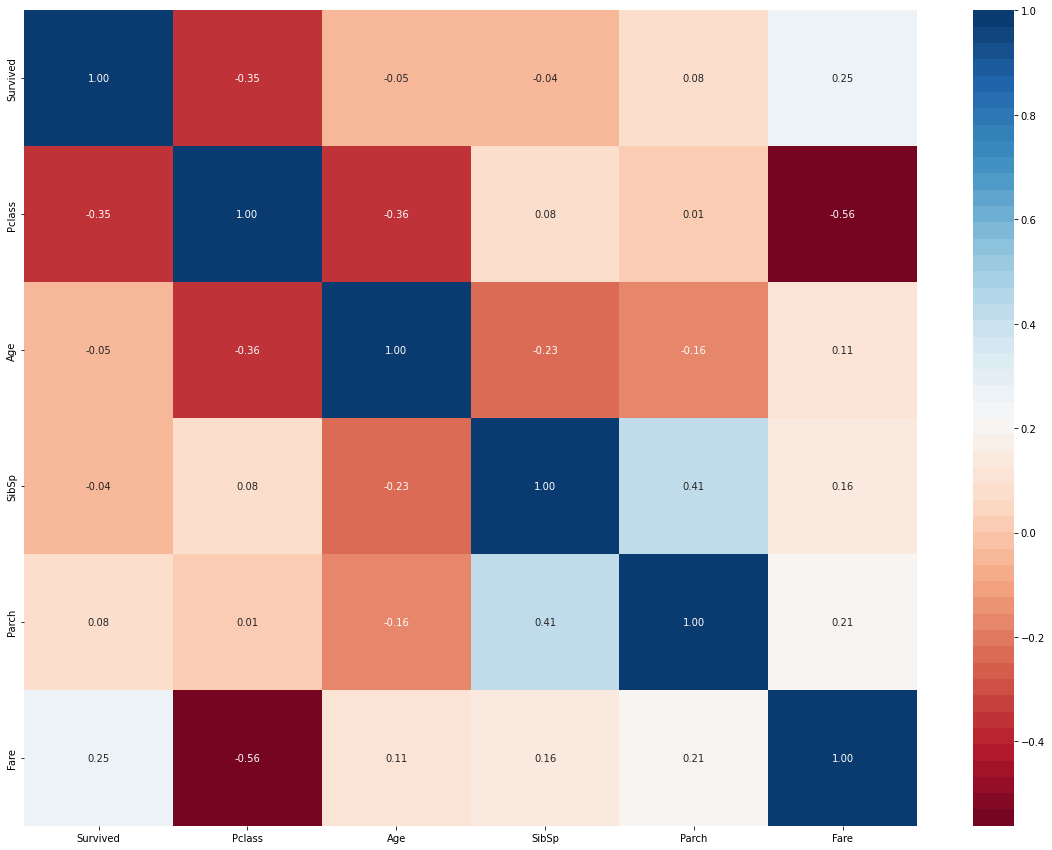

In [19]:
# correlations between the columns
plt.figure(figsize=(20, 15))
sns.heatmap(clean_train.corr(), annot=True, cmap=sns.color_palette('RdBu',50), fmt='.2f')

In [20]:
corr = clean_train.corr().abs()
sort = corr.sort_values(by=['Survived'],ascending=False)
print("Correlation of each variable to Survived:")
sort['Survived']

Correlation of each variable to Survived:


Survived    1.000000
Pclass      0.351636
Fare        0.252453
Parch       0.076939
Age         0.052087
SibSp       0.040941
Name: Survived, dtype: float64

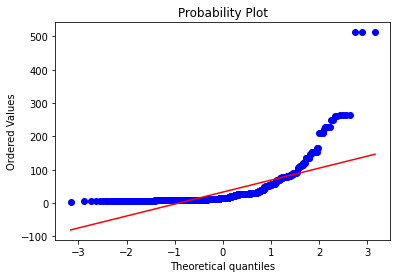

In [21]:
#qqplot
stats.probplot(clean_train['Fare'], dist="norm", plot=pylab)
pylab.show()

0.052115247804479584

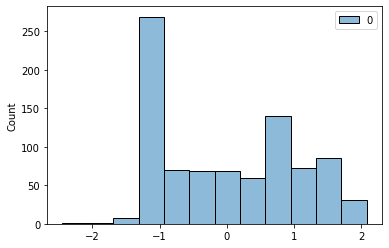

In [22]:
#Transformation decreases correlation so not going to transform
pt = PowerTransformer()
fare_transformed = pt.fit_transform(clean_train['Fare'].values.reshape(-1, 1))
sns.histplot(fare_transformed)

# Compute the correlation between the transformed fare column and survival rate
corr_transformed = pd.Series(fare_transformed.flatten()).corr(clean_train['Survived'])
corr_transformed 

In [23]:
clean_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


**Duplicates**

In [24]:
duplicated_rows = train.duplicated()
print(f'Number of Duplicated Rows for Train: {duplicated_rows.sum()}')
duplicated_rows = test.duplicated()
print(f'Number of Duplicated Rows for Test: {duplicated_rows.sum()}')

Number of Duplicated Rows for Train: 0
Number of Duplicated Rows for Test: 0


**One-hot Encoding**

In [25]:
#clean_train.select_dtypes('object')
#print(clean_train['Sex'].unique())
#print(clean_train['Embarked'].unique())
#print(type(clean_train['Embarked'][0]))
q = clean_train[clean_train['Embarked']=='Q']
print(q)
#clean_train.dtypes

     Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
5           0       3    male  24.0      0      0   8.4583        Q
16          0       3    male   2.0      4      1  29.1250        Q
22          1       3  female  15.0      0      0   8.0292        Q
28          1       3  female  24.0      0      0   7.8792        Q
32          1       3  female  24.0      0      0   7.7500        Q
..        ...     ...     ...   ...    ...    ...      ...      ...
790         0       3    male  24.0      0      0   7.7500        Q
825         0       3    male  24.0      0      0   6.9500        Q
828         1       3    male  24.0      0      0   7.7500        Q
885         0       3  female  39.0      0      5  29.1250        Q
890         0       3    male  32.0      0      0   7.7500        Q

[77 rows x 8 columns]


In [27]:
#Since only 2/7 columns are categorical, I'm using one-hot encoding since there won't be that much sparsity 
'''
ohe = OneHotEncoder(handle_unknown='ignore')

train_object = clean_train.select_dtypes('object')
ohe.fit(train_object)

codes = ohe.transform(train_object).toarray()
feature_names = ohe.get_feature_names_out(['Sex', 'Embarked'])

clean_train = pd.concat([clean_train.select_dtypes(exclude='object'), 
               pd.DataFrame(codes,columns=feature_names).astype(int)], axis=1)
'''
'''
encoder = OneHotEncoder(handle_unknown='ignore')
#perform one-hot encoding on columns 
encoder_df = pd.DataFrame(encoder.fit_transform(clean_train[['Sex', 'Embarked']]).toarray())
#merge one-hot encoded columns back with original DataFrame
clean_train = clean_train.join(encoder_df)
#drop columns with strings
clean_train = clean_train.drop(columns=['Sex', 'Embarked'])
#showing new head
clean_train.head()

#x_cat_df.columns = ohenc.get_feature_names()
'''

'''
encoder=OneHotEncoder(handle_unknown='ignore')

clean_train_encoded = pd.DataFrame(encoder.fit_transform(clean_train[['Sex', 'Embarked']]))

clean_train_encoded.columns = encoder.get_feature_names_out()

clean_train = clean_train.drop(['Sex','Embarked'] ,axis=1, inplace=True)

clean_train= pd.concat([clean_train, clean_train_encoded ], axis=1)
clean_train.head()


# put dummy in missing_df
missing_df.drop('payment_type', axis=1, inplace=True)
missing_df = pd.concat([missing_df, dummy], axis=1)
'''
clean_train = pd.get_dummies(data=clean_train, columns=['Sex', 'Embarked'])
clean_train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,0,1,0,0,1


In [28]:
#30 rows with NaN are added after OneHotEncoder so I removed them all
null_mask = clean_train.isnull().any(axis=1)
null_rows = clean_train[null_mask]
print(null_rows)
#clean_train = clean_train.dropna()
#msno.matrix(clean_train)

Empty DataFrame
Columns: [Survived, Pclass, Age, SibSp, Parch, Fare, Sex_female, Sex_male, Embarked_C, Embarked_Q, Embarked_S]
Index: []


**Data Type Conversion**

In [170]:
#all values were converted to float after encoding
unique = [[clean_train[i].name,clean_train[i].unique()] for i in clean_train.columns]
unique

[['Survived', array([0., 1.])],
 ['Pclass', array([3., 1., 2.])],
 ['Age',
  array([22.  , 38.  , 26.  , 35.  , 24.  , 54.  ,  2.  , 27.  , 14.  ,
          4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
          8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
         49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
         16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 46.  , 59.  , 71.  ,
         37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 , 51.  ,
         55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  , 45.5 ,
         20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  , 60.  ,
         10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  , 70.  ,
         24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])],
 ['SibSp', array([1., 0., 3., 4., 2., 5., 8.])],
 ['Parch', array([0., 1., 2., 5., 3., 4., 6.])],
 ['Fare',
  array([  7.25  ,  71.2833,   7.925 ,  53.1   ,   8.05  ,   8.4583,
          51.8625,  21.075 ,  11.1333, 

In [171]:
#converting float to int for all columns that have whole number as float type
for col in clean_train.columns:
    if clean_train[col].dtype == 'float64' and all(clean_train[col].apply(lambda x: x.is_integer())):
        clean_train[col] = clean_train[col].astype(int)
clean_train.dtypes

Survived        int32
Pclass          int32
Age           float64
SibSp           int32
Parch           int32
Fare          float64
Sex_female      int32
Sex_male        int32
Embarked_C      int32
Embarked_Q      int32
Embarked_S      int32
dtype: object

# **Feature Engineering**

In [172]:
#categorical column = Pclass
#Num columns to be aggregated = Age(median,std), SibSp(count), Parch(count), Fare(median,std,actual-median)

grouped_train = clean_train.groupby('Pclass')

#Since age and fare distrubutions are skewed, I chose median
clean_train[['age_Pclass_median','fare_Pclass_median']] = grouped_train[['Age', 'Fare']].transform('median')

clean_train[['age_Pclass_std','fare_Pclass_std']] = grouped_train[['Age', 'Fare']].transform('std')

clean_train[['SibSp_count','Parch_count']] = grouped_train[['SibSp', 'Parch']].transform('count') 

#fare-median
clean_train['fare_median_diff'] = clean_train['Fare']-clean_train['fare_Pclass_median']

clean_train.sample(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,age_Pclass_median,fare_Pclass_median,age_Pclass_std,fare_Pclass_std,SibSp_count,Parch_count,fare_median_diff
341,1,1,24.0,3,2,263.0000,1,0,0,0,1,35.0,62.66875,14.686916,78.581058,208,208,200.33125
43,1,2,3.0,1,2,41.5792,1,0,1,0,0,29.0,15.04580,13.948199,13.149545,175,175,26.53340
36,1,3,24.0,0,0,7.2292,0,1,1,0,0,24.0,8.05000,10.666124,11.823268,478,478,-0.82080
486,1,1,35.0,1,0,90.0000,0,1,0,0,1,35.0,62.66875,14.686916,78.581058,208,208,27.33125
552,0,3,24.0,0,0,7.8292,0,1,0,1,0,24.0,8.05000,10.666124,11.823268,478,478,-0.22080
325,1,1,36.0,0,0,135.6333,1,0,0,1,0,35.0,62.66875,14.686916,78.581058,208,208,72.96455
631,0,3,51.0,0,0,7.0542,1,0,1,0,0,24.0,8.05000,10.666124,11.823268,478,478,-0.99580
62,0,1,45.0,1,0,83.4750,0,1,0,0,1,35.0,62.66875,14.686916,78.581058,208,208,20.80625
170,0,1,61.0,0,0,33.5000,0,1,0,0,1,35.0,62.66875,14.686916,78.581058,208,208,-29.16875
812,0,2,35.0,0,0,10.5000,0,1,1,0,0,29.0,15.04580,13.948199,13.149545,175,175,-4.54580


# Cleaning test data

In [192]:
clean_test = test.copy()
def clean(clean_test):
    clean_test = clean_test[clean_test['Fare']>0]
    clean_test = clean_test.drop(columns=['Ticket'])
    clean_test = clean_test.drop(columns=['Name'])
    clean_test = clean_test.drop(columns=['Cabin'])
    clean_test['Age'].fillna(clean_test['Age'].mode().iloc[0], inplace=True)
    clean_test['Embarked'].fillna(clean_test['Embarked'].mode().iloc[0], inplace=True)
    
    print(clean_test.iloc[152])
    print()
    ohe = OneHotEncoder(handle_unknown='ignore') 
    test_object = clean_test.select_dtypes('object')
    ohe.fit(test_object)
    codes = ohe.transform(test_object).toarray()
    feature_names = ohe.get_feature_names_out(['Sex', 'Embarked'])
    clean_test = pd.concat([clean_test.select_dtypes(exclude='object'), 
                   pd.DataFrame(codes,columns=feature_names)], axis=1)
    
    
    print(clean_test.iloc[152])
    print()
    #clean_test = clean_test.dropna() can't drop NA because submission requires 418 rows
    nan_mask = clean_test.isna().any(axis=1)

    # use the boolean mask to index the DataFrame and show only the rows with NaN values
    rows_with_nan = clean_test.loc[nan_mask]
    print(rows_with_nan)
    
    
    
    for col in clean_test.columns:
        if clean_test[col].dtype == 'float64' and all(clean_test[col].apply(lambda x: x.is_integer())):
            clean_test[col] = clean_test[col].astype(int)
            
    grouped_test = clean_test.groupby('Pclass')

    clean_test[['age_Pclass_median','fare_Pclass_median']] = grouped_test[['Age', 'Fare']].transform('median')
    clean_test[['age_Pclass_std','fare_Pclass_std']] = grouped_test[['Age', 'Fare']].transform('std')
    clean_test[['SibSp_count','Parch_count']] = grouped_test[['SibSp', 'Parch']].transform('count') 
    clean_test['fare_median_diff'] = clean_test['Fare']-clean_test['fare_Pclass_median']
    return clean_test

clean_test = clean(clean_test)
#clean_test.head()

PassengerId       1045
Pclass               3
Sex             female
Age               36.0
SibSp                0
Parch                2
Fare           12.1833
Embarked             S
Name: 153, dtype: object

PassengerId    NaN
Pclass         NaN
Age            NaN
SibSp          NaN
Parch          NaN
Fare           NaN
Sex_female     1.0
Sex_male       0.0
Embarked_C     0.0
Embarked_Q     0.0
Embarked_S     1.0
Name: 152, dtype: float64

     PassengerId  Pclass   Age  SibSp  Parch     Fare  Sex_female  Sex_male  \
152          NaN     NaN   NaN    NaN    NaN      NaN         1.0       0.0   
266          NaN     NaN   NaN    NaN    NaN      NaN         1.0       0.0   
372          NaN     NaN   NaN    NaN    NaN      NaN         1.0       0.0   
415       1307.0     3.0  38.5    0.0    0.0   7.2500         NaN       NaN   
416       1308.0     3.0  21.0    0.0    0.0   8.0500         NaN       NaN   
417       1309.0     3.0  21.0    1.0    1.0  22.3583         NaN       NaN   



**Duplicates after cleaning**

In [174]:
train_dup_rows = clean_train.duplicated()
test_dup_rows = clean_test.duplicated()


print(f'Number of Duplicated Rows: {train_dup_rows.sum()}')
print(f'Number of Duplicated Rows: {test_dup_rows.sum()}')
print(f'Shape of train data before dropping Survived col:{clean_train.shape}')
print(f'Shape of train data before dropping Survived col:{clean_test.shape}')


dup = clean_train[train_dup_rows]
# display the duplicate rows
#print(dup)
clean_test.head()

Number of Duplicated Rows: 66
Number of Duplicated Rows: 1
Shape of train data before dropping Survived col:(861, 18)
Shape of train data before dropping Survived col:(418, 18)


,PassengerId,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,age_Pclass_median,fare_Pclass_median,age_Pclass_std,fare_Pclass_std,SibSp_count,Parch_count,fare_median_diff
0,892.0,3.0,34.5,0.0,0.0,7.8292,0.0,1.0,0.0,1.0,0.0,21.0,7.8958,8.369618,10.803698,217.0,217.0,-0.0666
1,893.0,3.0,47.0,1.0,0.0,7.0000,1.0,0.0,0.0,0.0,1.0,21.0,7.8958,8.369618,10.803698,217.0,217.0,-0.8958
2,894.0,2.0,62.0,0.0,0.0,9.6875,0.0,1.0,0.0,1.0,0.0,26.0,15.7500,12.709790,13.991877,93.0,93.0,-6.0625
3,895.0,3.0,27.0,0.0,0.0,8.6625,0.0,1.0,0.0,0.0,1.0,21.0,7.8958,8.369618,10.803698,217.0,217.0,0.7667
4,896.0,3.0,22.0,1.0,1.0,12.2875,1.0,0.0,0.0,0.0,1.0,21.0,7.8958,8.369618,10.803698,217.0,217.0,4.3917


# **Baseline Model**

In [175]:
#log regression; only using Pclass variable as it has highest correlation with Survived

y_train = clean_train['Survived']
x_train = clean_train.drop(columns=['Survived'])

x_test = clean_test.drop(columns=['PassengerId'])
ids = clean_test['PassengerId'].values


sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

baseline = LogisticRegression(class_weight="balanced")
baseline.fit(x_train, y_train)


predictions = logisticRegr.predict(x_test)

#submission file
sub = pd.DataFrame()
sub['PassengerId'] = ids.astype('int')
sub['Survived'] = predictions

subfolder_name = 'Submission'
filename = 'baseline.csv'
filepath = os.path.join(subfolder_name, filename)
sub.to_csv(filepath, index=False, float_format='%.5f')
print("Done!")

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values